## ESPN fantasy basketball team analysis 🏀

Environment variables `ESPN_S2` and `ESPN_SWID` can be copied from the fantasy home (opened in browser) > application > cookies.

In [1]:
import os
from dotenv import load_dotenv
from espn_api.basketball import League

load_dotenv()
LEAGUE_NAME = os.getenv('LEAGUE_NAME')
LEAGUE = League(league_id=int(os.getenv('LEAGUE_ID')),
                year=int(os.getenv('YEAR')),
                espn_s2=os.getenv('ESPN_S2'),
                swid=os.getenv('ESPN_SWID'))


print(LEAGUE_NAME, 'teams', LEAGUE.teams)

Rozna Dolina association teams [Team(Lebron is my goat), Team(Marko's Magnificent Team), Team(Team Francetovi ), Team(Postojna Bevery Hills), Team(Rozna Dolina Tweakers), Team(Rozna dolina c2), Team(Drustvo telesne vadbe), Team(HalleLuka), Team(Sharks), Team(Kanta Team)]


## Script development

In [2]:
team = LEAGUE.teams[0]


print(team.team_name, 'roster', team.roster)

Lebron is my goat roster [Player(Cade Cunningham), Player(James Harden), Player(Paolo Banchero), Player(Jalen Johnson), Player(Jaren Jackson Jr.), Player(De'Aaron Fox), Player(Trey Murphy III), Player(Andrew Wiggins), Player(Onyeka Okongwu), Player(Matas Buzelis), Player(Jared McCain), Player(Domantas Sabonis), Player(Tyler Herro), Player(Ryan Kalkbrenner)]


In [3]:
PLAYER_CATEGORIES = ['FGA', 'FGM', 'FTA', 'FTM', '3PM', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS']

def get_player_stats(player):
    try:
        player_stats = player.stats[f"{os.getenv('YEAR')}_total"]['avg']
    except:
        print('Using projections for', player.name)
        player_stats = player.stats[f"{os.getenv('YEAR')}_projected"]['avg']
    
    player_stats = {cat: player_stats[cat] for cat in PLAYER_CATEGORIES}
    return player_stats


player = team.roster[0]
print(player.name, 'avg stats', get_player_stats(player))

Cade Cunningham avg stats {'FGA': 22.09090909090909, 'FGM': 9.636363636363637, 'FTA': 7.818181818181818, 'FTM': 6.2727272727272725, '3PM': 1.9090909090909092, 'REB': 5.363636363636363, 'AST': 9.909090909090908, 'STL': 1.3636363636363635, 'BLK': 0.8181818181818182, 'TO': 3.6363636363636362, 'PTS': 27.454545454545453}


In [4]:
TEAM_CATEGORIES = ['FG%', 'FT%', '3PM', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS']

def get_team_stats(team):
    team_roster = [player for player in team.roster if player.lineupSlot != 'IR']
    team_stats = {cat: 0 for cat in PLAYER_CATEGORIES}
    for player in team_roster:
        player_stats = get_player_stats(player)
        for cat in PLAYER_CATEGORIES:
            team_stats[cat] += player_stats[cat]
    
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FT%'] = team_stats['FTM'] / team_stats['FTA']
    team_stats = {cat: team_stats[cat] for cat in TEAM_CATEGORIES}
    return team_stats


print(team.team_name, 'avg stats', get_team_stats(team))

Lebron is my goat avg stats {'FG%': 0.49312433545059176, 'FT%': 0.800364738203735, '3PM': 18.272979797979797, 'REB': 82.37626262626262, 'AST': 49.47146464646465, 'STL': 12.048484848484849, 'BLK': 9.062878787878788, 'TO': 30.642676767676768, 'PTS': 221.8449494949495}


In [5]:
def get_league_stats():
    league_stats = {cat: 0 for cat in TEAM_CATEGORIES}
    n_teams = len(LEAGUE.teams)
    for team in LEAGUE.teams:
        team_stats = get_team_stats(team)
        for cat in TEAM_CATEGORIES:
            league_stats[cat] += team_stats[cat]
    
    for cat in TEAM_CATEGORIES:
        league_stats[cat] /= n_teams
    return league_stats


print(LEAGUE_NAME, 'avg stats', get_league_stats())

Rozna Dolina association avg stats {'FG%': 0.48240824085237, 'FT%': 0.8125553553710544, '3PM': 22.82121212121212, 'REB': 76.43551948051949, 'AST': 50.76630230880231, 'STL': 13.840032467532467, 'BLK': 7.761883116883117, 'TO': 27.085541125541123, 'PTS': 226.46231240981243}


In [6]:
import math

def get_league_min():
    league_min = {cat: math.inf for cat in TEAM_CATEGORIES}
    for team in LEAGUE.teams:
        team_stats = get_team_stats(team)
        for cat in TEAM_CATEGORIES:
            league_min[cat] = min(league_min[cat], team_stats[cat])
    return league_min

def get_league_max():
    league_max = {cat: -math.inf for cat in TEAM_CATEGORIES}
    for team in LEAGUE.teams:
        team_stats = get_team_stats(team)
        for cat in TEAM_CATEGORIES:
            league_max[cat] = max(league_max[cat], team_stats[cat])
    return league_max


print(LEAGUE_NAME, 'min stats', get_league_min())
print(LEAGUE_NAME, 'max stats', get_league_max())

Rozna Dolina association min stats {'FG%': 0.4581131150862521, 'FT%': 0.7628488712510573, '3PM': 18.04570707070707, 'REB': 52.37904040404041, 'AST': 34.723196248196246, 'STL': 10.167929292929292, 'BLK': 5.148773448773449, 'TO': 22.43852813852814, 'PTS': 202.50068542568542}
Rozna Dolina association max stats {'FG%': 0.5123656845662888, 'FT%': 0.8696714114344369, '3PM': 28.50865800865801, 'REB': 93.11262626262626, 'AST': 57.38358585858586, 'STL': 16.693686868686868, 'BLK': 10.782828282828284, 'TO': 30.642676767676768, 'PTS': 259.3047258297258}


## Min max normalization

https://en.wikipedia.org/wiki/Feature_scaling

In [7]:
def normalize_stats(stats, min, max):
    for cat in TEAM_CATEGORIES:
        stats[cat] = (stats[cat] - min[cat]) / (max[cat] - min[cat])
    return stats


print(team.team_name, 'normalized stats', normalize_stats(get_team_stats(team), get_league_min(), get_league_max()))

Lebron is my goat normalized stats {'FG%': 0.6453375517490044, 'FT%': 0.35119804198884563, '3PM': 0.021721666155230548, 'REB': 0.7364247853445334, 'AST': 0.6508391361244045, 'STL': 0.28817428991564137, 'BLK': 0.6947226206331316, 'TO': 1.0, 'PTS': 0.34054380518833943}


In [8]:
def get_team_delta(team):
    team_stats = get_team_stats(team)
    league_stats = get_league_stats()
    normalized_team_stats = normalize_stats(team_stats, get_league_min(), get_league_max())
    normalized_league_stats = normalize_stats(league_stats, get_league_min(), get_league_max())
    
    team_delta = {cat: normalized_team_stats[cat] - normalized_league_stats[cat] for cat in TEAM_CATEGORIES}
    return team_delta


print(team.team_name, 'stats delta', get_team_delta(team))

Lebron is my goat stats delta {'FG%': 0.1975223422766169, 'FT%': -0.11412027036983075, '3PM': -0.43469881013539835, 'REB': 0.14584385392357824, 'AST': -0.057141014986961336, 'STL': -0.2745348104414738, 'BLK': 0.2309164020079909, 'TO': 0.43357766941196696, 'PTS': -0.08128581843862115}


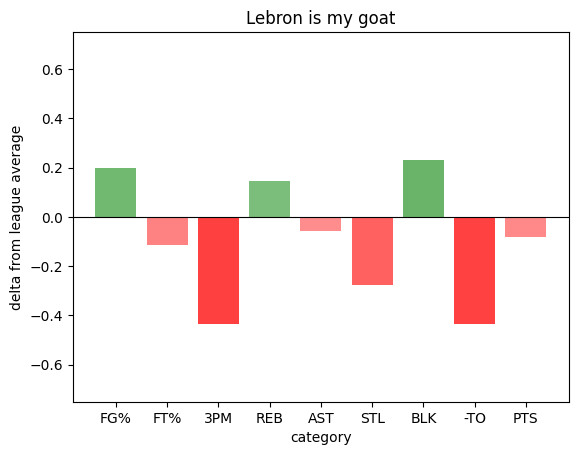

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DISPLAY_CATEGORIES = ['FG%', 'FT%', '3PM', 'REB', 'AST', 'STL', 'BLK', '-TO', 'PTS']


def calculate_alpha(value):
    return 0.4 + abs(value) * 0.8

def plot_team_delta(team):
    team_delta = get_team_delta(team)
    display_team_delta = {cat: 0 for cat in DISPLAY_CATEGORIES}
    for cat in DISPLAY_CATEGORIES:
        if cat == '-TO':
            display_team_delta[cat] = -team_delta['TO']
        else:
            display_team_delta[cat] = team_delta[cat]

    display_colors = []
    for cat in DISPLAY_CATEGORIES:
        delta = display_team_delta[cat]
        if delta > 0:
            display_colors.append(mcolors.to_rgba('green', calculate_alpha(delta)))
        else:
            display_colors.append(mcolors.to_rgba('red', calculate_alpha(delta)))

    plt.bar(display_team_delta.keys(), display_team_delta.values(), color=display_colors)
    plt.axhline(y=0, color='black', linewidth=0.8)
    plt.ylim(-0.75, 0.75)
    plt.title(team.team_name.strip())
    plt.xlabel('category')
    plt.ylabel('delta from league average')


plot_team_delta(team)
plt.show()

## Final results

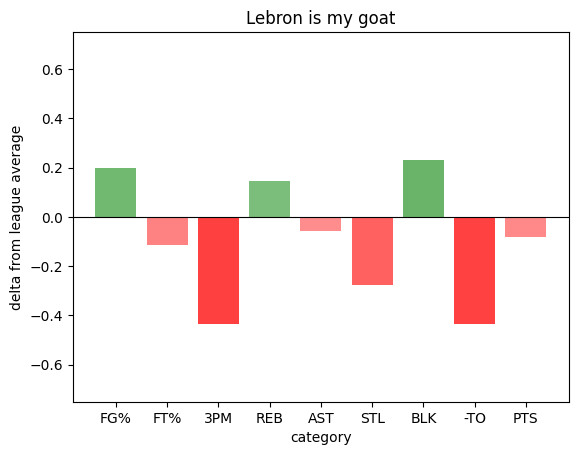

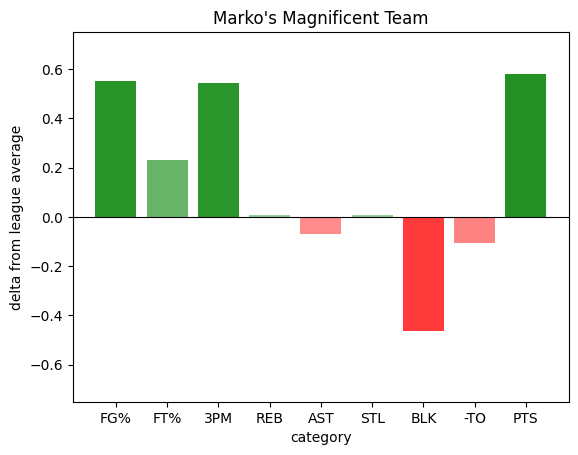

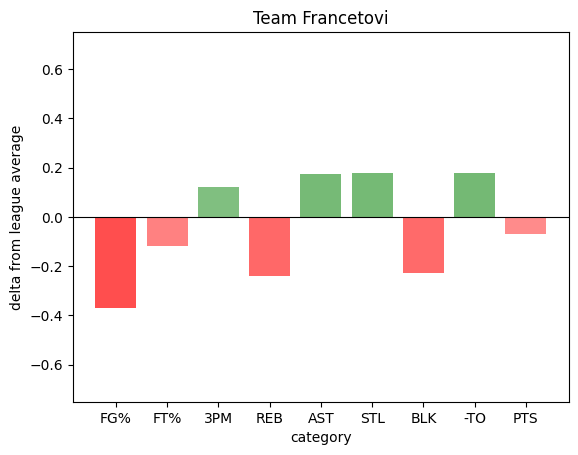

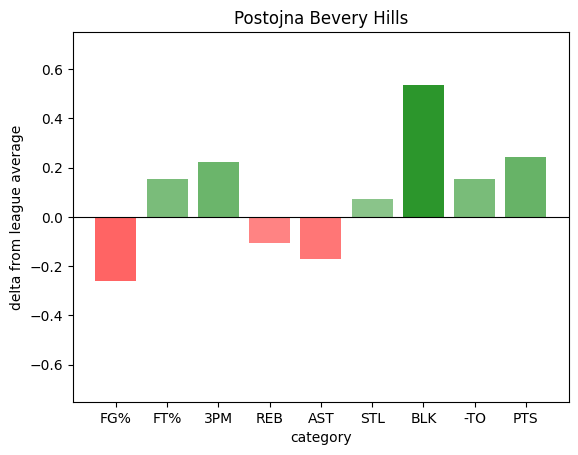

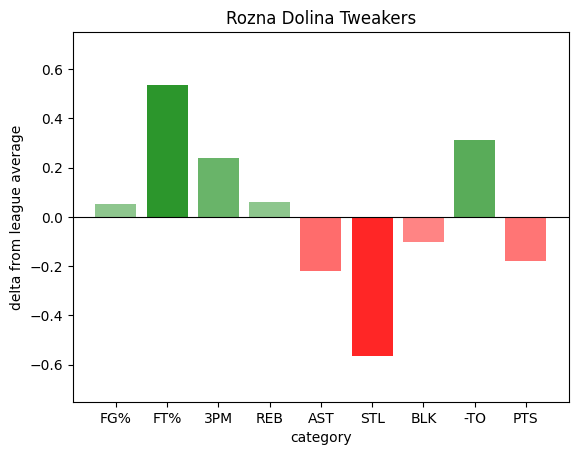

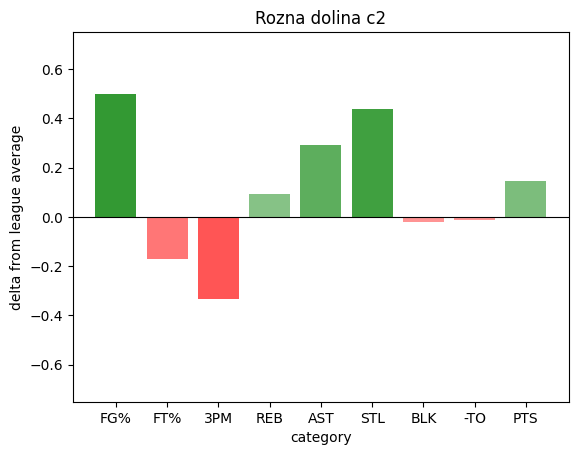

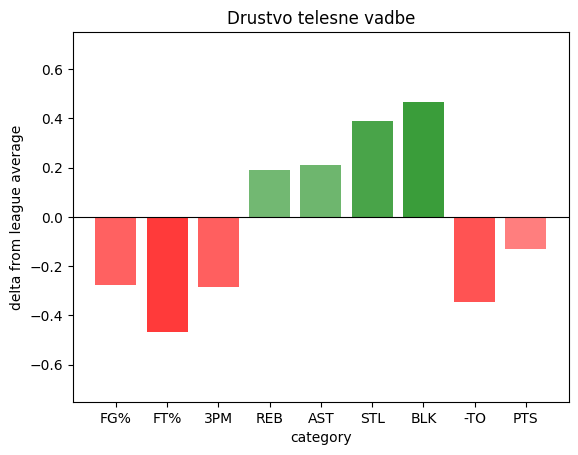

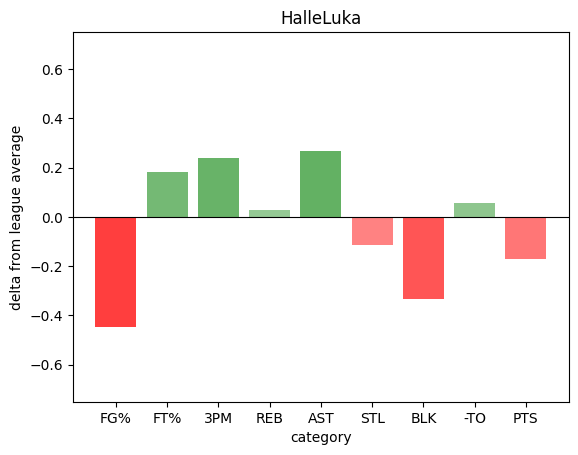

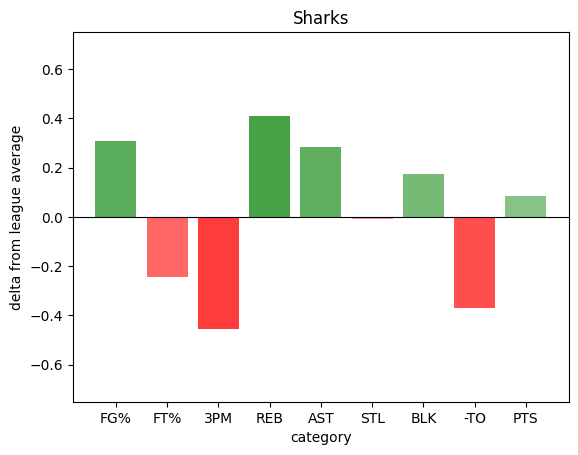

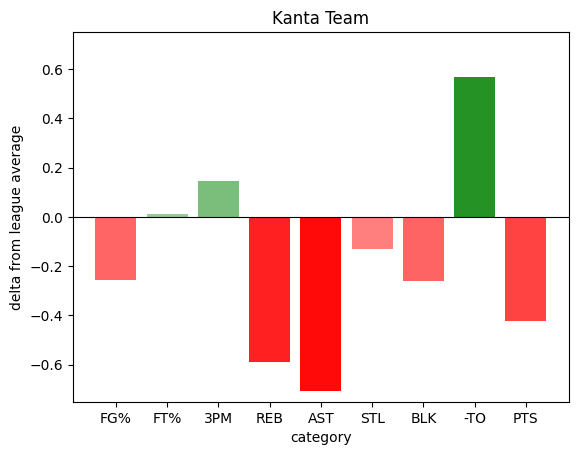

In [10]:
DIR_NAME = './out'


os.makedirs(DIR_NAME, exist_ok=True)
for team in LEAGUE.teams:
    plot_team_delta(team)
    file_name = team.team_name.strip() + '.png'
    file_path = os.path.join(DIR_NAME, file_name)

    plt.savefig(file_path)
    plt.show()